<h1 style="text-align: center; font-style: italic; color: tomato;;">Sentiment Analysis for Movies Comment</h1>
<p style="text-align: center; font-style: italic; color: tomato;">Classifying text as positive or negative sentiment.</p>



<img src="cover.jpg" alt="Cover Image">>



In [ ]:
Table of Content 

<h1 style="text-align: center; font-style: italic; color: tomato;">1. Problem Definition</h1>

<h1 style="text-align: center; font-style: italic; color: tomato;">What is Sentiment Analysis</h1>
<p style= "font-style: italic;">Sentiment analysis is the process of reading tons of product reviews automatically and extract useful and meaningful information to discover if the customers are really satisfied with your product or not.
A person’s feedback is more subjective rather than factual. Feedbacks can be negative, positive, or neutral.
Sentiment analysis applies Natural Language Processing (NLP) and Text Analysis techniques to highlight the subjective information from the text</p>

<h1 style="text-align: center; font-style: italic; color: tomato;">2. Imported Libraries</h1>




In [36]:
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.metrics import Accuracy
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import  Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Embedding, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

<h1 style="text-align: center; font-style: italic; color: tomato;">3. Data Preparation and Loading Data</h1>

In [10]:
data = pd.read_csv("IMDB Dataset.csv")
critics = pd.read_csv("rotten_tomatoes_critic_reviews.csv")

In [11]:
data.head(7)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive


In [12]:
data.shape, critics.shape

((50000, 2), (1130017, 8))

In [14]:
data.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [15]:
critics.head(7)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...
5,m/0814255,David Germain,True,Associated Press,Rotten,NaN,2010-02-10,It's more a list of ingredients than a movie-m...
6,m/0814255,Nick Schager,False,Slant Magazine,Rotten,1/4,2010-02-10,Harry Potter knockoffs don't come more transpa...


In [16]:
critics.review_type.value_counts()

review_type
Fresh     720210
Rotten    409807
Name: count, dtype: int64

In [17]:
reviewData = critics[["review_type", "review_content"]]
reviewData.head(7)

,review_type,review_content
0,Fresh,A fantasy adventure that fuses Greek mythology...
1,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,Fresh,With a top-notch cast and dazzling special eff...
3,Fresh,Whether audiences will get behind The Lightnin...
4,Rotten,What's really lacking in The Lightning Thief i...
5,Rotten,It's more a list of ingredients than a movie-m...
6,Rotten,Harry Potter knockoffs don't come more transpa...


<h1 style="text-align: center; font-style: italic; color: tomato;">4. Text Preprocessing and Data Cleaning</h1>
<p style="font-style:italic; text-align: center;"> Before everything we have to clean and process on our data before applying any algorithm. </p>

In [18]:
data["label"] = data["sentiment"].apply(lambda x:1 if x == "positive" else 0)

In [19]:
data.head(7)

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
5,"Probably my all-time favorite movie, a story o...",positive,1
6,I sure would like to see a resurrection of a u...,positive,1


In [20]:
reviewData["label"] = reviewData["review_type"].apply(lambda x:1 if x == "Fresh" else 0)

C:\Users\DELL\AppData\Local\Temp\ipykernel_11872\2933184578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviewData["label"] = reviewData["review_type"].apply(lambda x:1 if x == "Fresh" else 0)


In [21]:
reviewData.head()

,review_type,review_content,label
0,Fresh,A fantasy adventure that fuses Greek mythology...,1
1,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",1
2,Fresh,With a top-notch cast and dazzling special eff...,1
3,Fresh,Whether audiences will get behind The Lightnin...,1
4,Rotten,What's really lacking in The Lightning Thief i...,0


In [52]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data['review'].value_counts()
vc.plot.barh(color="blue", fontsize=14, ax=ax)
ax.set_title("Label vs Count", fontsize=15)
ax.set_xlabel("Count", fontsize=14)
ax.set_ylabel("Label", fontsize=14)
plt.show()

C:\Users\DELL\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DELL\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\DELL\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 145 (\x91) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: 
Words can scarcely describe this movie. Loaded with ridiculous stereotypes, a silly plot, and poor music, this movie lacks in just about every category.<br /><br />Don't be fooled by the IMDB credits. This is not a Michael Dorn movie. He's a secondary character in the grand scheme.<br /><br />Also listed in the Credit's is an actor named "Prince" - which makes me wonder if it's the same artist formerly known as.... Then again, I'm not sure this movie is worth watching just for that.<br /><br />Big summary... bunch of teams... one has kidneys... one has $35,000.... one has an "Illegal Substance".... and one has $350,000. Add some confusion and mixups as to who needs to meet who, revenge on being taken, and such, and you end up with this mess of a movie.<br /><br />Given a choice, I'd pass on this movie.
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               ^
ParseException: Expected end of text, found '$'  (at char 559), (line:1, col:560)

<Figure size 1600x600 with 1 Axes>

<h1 style="text-align: center; font-style: italic; color: tomato;">5. Clearning Text</h1>
<p style="text-align: center; font-style: italic;">Using regex the `re` module is utilized for finding reviews within the DataFrame.</p>

In [18]:
review = re.sub(r'^RT[\s]+', '', data.iloc[1]["review"])
review = re.sub(r'<br />', '', review)
review = review.replace("\'", "")
print(review)

A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great masters of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional dream techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwells murals decorating every surface) are terribly well done.


In [19]:
tokens = review.split()
print(tokens)

['A', 'wonderful', 'little', 'production.', 'The', 'filming', 'technique', 'is', 'very', 'unassuming-', 'very', 'old-time-BBC', 'fashion', 'and', 'gives', 'a', 'comforting,', 'and', 'sometimes', 'discomforting,', 'sense', 'of', 'realism', 'to', 'the', 'entire', 'piece.', 'The', 'actors', 'are', 'extremely', 'well', 'chosen-', 'Michael', 'Sheen', 'not', 'only', '"has', 'got', 'all', 'the', 'polari"', 'but', 'he', 'has', 'all', 'the', 'voices', 'down', 'pat', 'too!', 'You', 'can', 'truly', 'see', 'the', 'seamless', 'editing', 'guided', 'by', 'the', 'references', 'to', 'Williams', 'diary', 'entries,', 'not', 'only', 'is', 'it', 'well', 'worth', 'the', 'watching', 'but', 'it', 'is', 'a', 'terrificly', 'written', 'and', 'performed', 'piece.', 'A', 'masterful', 'production', 'about', 'one', 'of', 'the', 'great', 'masters', 'of', 'comedy', 'and', 'his', 'life.', 'The', 'realism', 'really', 'comes', 'home', 'with', 'the', 'little', 'things:', 'the', 'fantasy', 'of', 'the', 'guard', 'which,', '

In [20]:
len(tokens)

156

<h1 style="text-align: center; font-style: italic; color: tomato;">6. Preprocessing Textual Data</h1>

In [21]:
nltk.download('stopwords')
stopwords_english = stopwords.words("english")
cleaned_words = [x for x in tokens if x.lower() not in stopwords_english and x not in string.punctuation]

print(cleaned_words)


['wonderful', 'little', 'production.', 'filming', 'technique', 'unassuming-', 'old-time-BBC', 'fashion', 'gives', 'comforting,', 'sometimes', 'discomforting,', 'sense', 'realism', 'entire', 'piece.', 'actors', 'extremely', 'well', 'chosen-', 'Michael', 'Sheen', '"has', 'got', 'polari"', 'voices', 'pat', 'too!', 'truly', 'see', 'seamless', 'editing', 'guided', 'references', 'Williams', 'diary', 'entries,', 'well', 'worth', 'watching', 'terrificly', 'written', 'performed', 'piece.', 'masterful', 'production', 'one', 'great', 'masters', 'comedy', 'life.', 'realism', 'really', 'comes', 'home', 'little', 'things:', 'fantasy', 'guard', 'which,', 'rather', 'use', 'traditional', 'dream', 'techniques', 'remains', 'solid', 'disappears.', 'plays', 'knowledge', 'senses,', 'particularly', 'scenes', 'concerning', 'Orton', 'Halliwell', 'sets', '(particularly', 'flat', 'Halliwells', 'murals', 'decorating', 'every', 'surface)', 'terribly', 'well', 'done.']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
print("Cleaned Word",len(cleaned_words), "|", "Uncleaned Words", len(tokens))

Cleaned Word 87 | Uncleaned Words 156


In [23]:
stemmer = PorterStemmer()
stopwords_english = stopwords.words("english")
cleaned_stemmed_words = [stemmer.stem(x) for x in tokens if x.lower() not in stopwords_english and x not in string.punctuation]
for i in range(len(cleaned_words)):
    print(f"{cleaned_words[i]} ----- {cleaned_stemmed_words[i]}")
    

wonderful ----- wonder
little ----- littl
production. ----- production.
filming ----- film
technique ----- techniqu
unassuming- ----- unassuming-
old-time-BBC ----- old-time-bbc
fashion ----- fashion
gives ----- give
comforting, ----- comforting,
sometimes ----- sometim
discomforting, ----- discomforting,
sense ----- sens
realism ----- realism
entire ----- entir
piece. ----- piece.
actors ----- actor
extremely ----- extrem
well ----- well
chosen- ----- chosen-
Michael ----- michael
Sheen ----- sheen
"has ----- "ha
got ----- got
polari" ----- polari"
voices ----- voic
pat ----- pat
too! ----- too!
truly ----- truli
see ----- see
seamless ----- seamless
editing ----- edit
guided ----- guid
references ----- refer
Williams ----- william
diary ----- diari
entries, ----- entries,
well ----- well
worth ----- worth
watching ----- watch
terrificly ----- terrificli
written ----- written
performed ----- perform
piece. ----- piece.
masterful ----- master
production ----- product
one ----- one
grea

In [24]:
nltk.download('stopwords')

def preprocessing(text):
    text = str(text)
    
    # Remove retweets (RT)
    text = re.sub(r'^RT[\s]+', '', text)
    
    # Remove HTML line breaks
    text = re.sub(r'<br />', '', text)
    
    # Remove apostrophes
    text = text.replace("\'", "")
    
    # Tokenize text
    tokens = text.split()
    
    # Get English stopwords
    stopwords_english = stopwords.words("english")
    
    # Initialize the stemmer
    stemmer = PorterStemmer()
    
    # Clean and stem tokens
    cleaned_words = [stemmer.stem(x) for x in tokens if x.lower() not in stopwords_english and x not in string.punctuation]
    
    return ' '.join(cleaned_words)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
print(cleaned_words)

['wonderful', 'little', 'production.', 'filming', 'technique', 'unassuming-', 'old-time-BBC', 'fashion', 'gives', 'comforting,', 'sometimes', 'discomforting,', 'sense', 'realism', 'entire', 'piece.', 'actors', 'extremely', 'well', 'chosen-', 'Michael', 'Sheen', '"has', 'got', 'polari"', 'voices', 'pat', 'too!', 'truly', 'see', 'seamless', 'editing', 'guided', 'references', 'Williams', 'diary', 'entries,', 'well', 'worth', 'watching', 'terrificly', 'written', 'performed', 'piece.', 'masterful', 'production', 'one', 'great', 'masters', 'comedy', 'life.', 'realism', 'really', 'comes', 'home', 'little', 'things:', 'fantasy', 'guard', 'which,', 'rather', 'use', 'traditional', 'dream', 'techniques', 'remains', 'solid', 'disappears.', 'plays', 'knowledge', 'senses,', 'particularly', 'scenes', 'concerning', 'Orton', 'Halliwell', 'sets', '(particularly', 'flat', 'Halliwells', 'murals', 'decorating', 'every', 'surface)', 'terribly', 'well', 'done.']


In [26]:
data["cleaned_text"] = data["review"].apply(preprocessing)

In [27]:
print(data["cleaned_text"])

0        one review mention watch 1 oz episod youll hoo...
1        wonder littl production. film techniqu unassum...
2        thought wonder way spend time hot summer weeke...
3        basic there famili littl boy (jake) think ther...
4        petter mattei "love time money" visual stun fi...
                               ...                        
49995    thought movi right good job. wasnt creativ ori...
49996    bad plot, bad dialogue, bad acting, idiot dire...
49997    cathol taught parochi elementari school nuns, ...
49998    im go disagre previou comment side maltin one....
49999    one expect star trek movi high art, fan expect...
Name: cleaned_text, Length: 50000, dtype: object


In [28]:
rev = reviewData[:1200]
# here updating the txt to cleaned 
reviewData["cleaned_text"] = reviewData["review_content"].apply(preprocessing)

C:\Users\DELL\AppData\Local\Temp\ipykernel_20732\4099191809.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviewData["cleaned_text"] = reviewData["review_content"].apply(preprocessing)


In [29]:
reviewData.head(7)

,review_type,review_content,label,cleaned_text
0,Fresh,A fantasy adventure that fuses Greek mythology...,1,fantasi adventur fuse greek mytholog contempor...
1,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",1,"uma thurman medusa, gorgon coiffur writh snake..."
2,Fresh,With a top-notch cast and dazzling special eff...,1,"top-notch cast dazzl special effects, tide tee..."
3,Fresh,Whether audiences will get behind The Lightnin...,1,whether audienc get behind lightn thief hard p...
4,Rotten,What's really lacking in The Lightning Thief i...,0,what realli lack lightn thief genuin sens wond...
5,Rotten,It's more a list of ingredients than a movie-m...,0,list ingredi movie-mag potion enjoy start finish.
6,Rotten,Harry Potter knockoffs don't come more transpa...,0,harri potter knockoff dont come transpar slapd...


<h1 style="text-align: center; font-style: italic; color: tomato;">7. Training Cleaned data using Label</h1>


In [32]:
X = data["cleaned_text"]
y = data["label"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

<h1 style="text-align: center; font-style: italic; color: tomato;">8. Tokenization and Padding</h1>
<p style="font-style:italic; text-align: center;">Tokenizes the text data into sequences of integers and pads them to ensure uniform input length.</p>


In [37]:
tokenizer = Tokenizer(num_words = 5000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_x)

train_x_sequences = tokenizer.texts_to_sequences(train_x)
test_x_sequences = tokenizer.texts_to_sequences(test_x)

max_length = 100
train_x_padded = pad_sequences(train_x_sequences, maxlen=max_length, padding='post', truncating='post')
test_x_padded = pad_sequences(test_x_sequences, maxlen=max_length, padding='post', truncating='post')

In [38]:
train_x_tomato = reviewData["cleaned_text"]
tokenizer.fit_on_texts(train_x_tomato)
train_x_tomato_sequences = tokenizer.texts_to_sequences(train_x_tomato)
train_x_tomato_padded = pad_sequences(train_x_tomato_sequences, maxlen=max_length, padding='post', truncating='post')

In [39]:
len(train_x_tomato)

1130017

<h1 style="text-align: center; font-style: italic; color: tomato;">9. Building and Training the Sentiment Analysis Model</h1>
<p style= "font-style:italic; text-align: center;">Defines an LSTM model for sentiment analysis, compiles it, trains it on the training data, and evaluates its performance on the test data.</p>

In [47]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation = "sigmoid")
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.summary()
# Training the model
history = model.fit(train_x_padded, train_y, epochs=5, batch_size=32, validation_split=0.2)

# Evaluating the model
loss, accuracy = model.evaluate(test_x_padded, test_y)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 100, 64)               │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (32, 100, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 100, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (32, 64)                    │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 1)                     │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,158,341 (4.42 MB)

 Trainable params: 386,113 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 772,228 (2.95 MB)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.5808 - loss: 0.6548 - val_accuracy: 0.5276 - val_loss: 0.6770
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.5861 - loss: 0.6481 - val_accuracy: 0.7950 - val_loss: 0.4389
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 73s 73ms/step - accuracy: 0.8355 - loss: 0.3855 - val_accuracy: 0.8487 - val_loss: 0.3512
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - accuracy: 0.8801 - loss: 0.3000 - val_accuracy: 0.8516 - val_loss: 0.3632
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 74s 74ms/step - accuracy: 0.9005 - loss: 0.2603 - val_accuracy: 0.8496 - val_loss: 0.3710
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8528 - loss: 0.3619
Test Loss: 0.3634406328201294
Test Accuracy: 0.8540999889373779


In [48]:
text_sample = [
    "It was an awful movie but I liked it.",
    "It was a good movie",
    "I think it was the only movie that I could see until the end because it wasn't like the other movies that I have ever seen"
]

text_sample_sequences = tokenizer.texts_to_sequences(text_sample)
max_length = 100
text_sample_padded = pad_sequences(text_sample_sequences, maxlen=max_length, padding='post', truncating='post')

predictions = model.predict(text_sample_padded)

print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[0.5047952]
 [0.5047952]
 [0.5047951]]


<h1 style="text-align: center; font-style: italic; color: tomato;">10. Sequence Autoencoder</h1>

<p  style= "font-style:italic; text-align: center;">Autoencoder to learn and compress the sequence representations</p>

In [50]:
max_length = 100
latent_dim = 64
vocab_size = 5000

In [51]:
inputs = Input(shape=(max_length,))
embedding = Embedding(vocab_size, latent_dim, input_length=max_length)(inputs)
encoded = LSTM(latent_dim, return_sequences=False)(embedding)

In [52]:
decoded = RepeatVector(max_length)(encoded)
decoded = LSTM(latent_dim, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoded)

In [54]:
sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

In [55]:
sequence_autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
sequence_autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 100, 64)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 100, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 100, 5000)           │         325,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 711,048 (2.71 MB)

 Trainable params: 711,048 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
sequence_autoencoder.fit(train_x_tomato_padded[:50000], np.expand_dims(train_x_tomato_padded[:50000], -1),
                         epochs=10,
                         batch_size=128,
                         validation_split=0.2)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 173s 504ms/step - accuracy: 0.0179 - loss: -888.3134 - val_accuracy: 0.0144 - val_loss: -1052.6573
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 441ms/step - accuracy: 0.0184 - loss: -1249.4999 - val_accuracy: 0.0144 - val_loss: -1064.8479
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 134s 427ms/step - accuracy: 0.0180 - loss: -1237.0099 - val_accuracy: 0.0144 - val_loss: -1064.8479
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 151s 481ms/step - accuracy: 0.0180 - loss: -1243.7577 - val_accuracy: 0.0144 - val_loss: -1064.8479
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 148s 473ms/step - accuracy: 0.0182 - loss: -1241.8625 - val_accuracy: 0.0144 - val_loss: -1064.8479
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 136s 436ms/step - accuracy: 0.0182 - loss: -1248.8688 - val_accuracy: 0.0144 - val_loss: -1064.8479
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 132s 422ms/step - accuracy: 0.0180 - loss: -1247.4900 - val_accuracy: 0.0144 - val_loss: -1064.8479
Epoch 8/10
313/313 ━━

In [58]:
# Define the input layer
input_seq = Input(shape=(max_length,))

# Embedding layer
embedded_seq = Embedding(input_dim=5000, output_dim=64, input_length=max_length)(input_seq)

# Encoder LSTM layer
encoded = LSTM(64)(embedded_seq)

# Repeat the encoded vector
repeated = RepeatVector(max_length)(encoded)

# Decoder LSTM layer
decoded = LSTM(64, return_sequences=True)(repeated)

# TimeDistributed layer with a Dense output layer
output_seq = TimeDistributed(Dense(1, activation='sigmoid'))(decoded)

# Create the sequence autoencoder model
sequence_autoencoder = Model(input_seq, output_seq)

# Compile the model
sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
sequence_autoencoder.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ (None, 100, 64)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 100, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 100, 1)              │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 386,113 (1.47 MB)

 Trainable params: 386,113 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Train the sequence autoencoder
history = sequence_autoencoder.fit(
    train_x_tomato_padded[:50000],                 # Input sequences for training
    np.expand_dims(train_x_tomato_padded[:50000], -1),  # Target sequences (reshaped to match output)
    epochs=10,                                     # Number of epochs to train
    batch_size=128,                                # Batch size for training
    validation_split=0.2                           # Fraction of training data to use for validation
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 177s 462ms/step - accuracy: 0.0181 - loss: -906.9754 - val_accuracy: 0.0144 - val_loss: -1052.6573
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 447ms/step - accuracy: 0.0180 - loss: -1247.6224 - val_accuracy: 0.0144 - val_loss: -1064.8479
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 446ms/step - accuracy: 0.0181 - loss: -1250.1199 - val_accuracy: 0.0144 - val_loss: -1064.8479
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 439ms/step - accuracy: 0.0180 - loss: -1244.7164 - val_accuracy: 0.0144 - val_loss: -1064.8479
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 148s 456ms/step - accuracy: 0.0182 - loss: -1245.2292 - val_accuracy: 0.0144 - val_loss: -1064.8479
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 217s 502ms/step - accuracy: 0.0182 - loss: -1243.8896 - val_accuracy: 0.0144 - val_loss: -1064.8479
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 161s 514ms/step - accuracy: 0.0181 - loss: -1249.6302 - val_accuracy: 0.0144 - val_loss: -1064.8479
Epoch 8/10
313/313 ━━

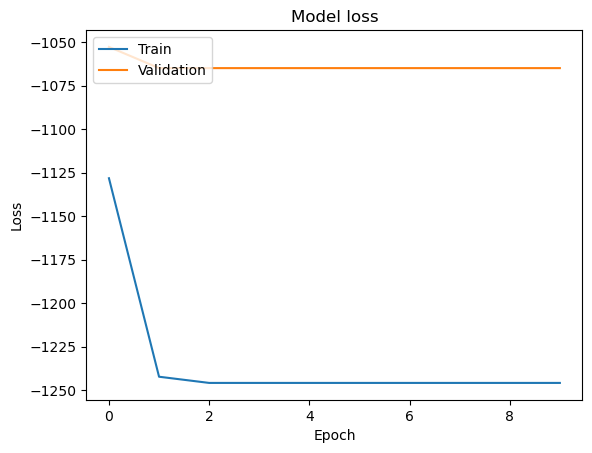

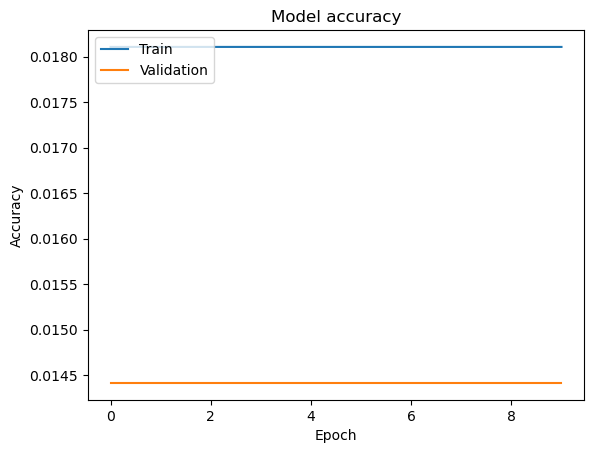

In [61]:
# Plot training & validation loss values
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [64]:
text_sample = [
    "It was awful movie but I liked it.",
    "It was a good movie",
    "I think it was the only movie that I could see until the end because it wasn't like the other movies that I have ever seen"
]
text_sample_cleaned = [preprocessing(text) for text in text_sample]

text_sample_sequences = tokenizer.texts_to_sequences(text_sample_cleaned)
text_sample_padded = pad_sequences(text_sample_sequences, maxlen=max_length, padding='post', truncating='post')

predictions = model.predict(text_sample_padded)
print(predictions)

for i, prediction in enumerate(predictions):
    print(f'Text: {text_sample[i]}')
    print(f'Predicted Sentiment: {"Positive" if prediction > 0.5 else "Negative"}\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
[[0.5047952]
 [0.5047952]
 [0.5047952]]
Text: It was awful movie but I liked it.
Predicted Sentiment: Positive

Text: It was a good movie
Predicted Sentiment: Positive

Text: I think it was the only movie that I could see until the end because it wasn't like the other movies that I have ever seen
Predicted Sentiment: Positive



In [65]:
sequence_autoencoder.save('sequence_autoencoder.h5')
encoder.save('encoder.h5')
model.save('sentiment_classifier.h5')

In [67]:
oaded_sequence_autoencoder = load_model('sequence_autoencoder.h5')
loaded_encoder = load_model('encoder.h5')
loaded_sentiment_classifier = load_model('sentiment_classifier.h5')

<h1 style="text-align: center; font-style: italic; color: tomato;">11. Embedding Layer with Pre-trained Model</h1>
<p style="text-align: center; font-style: italic;">Utilizes the Universal Sentence Encoder from TensorFlow Hub for embedding sentences.</p>


In [75]:
# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(data['review'], data['label'], test_size=0.2, random_state=42)

# Load the Universal Sentence Encoder model
pretrained_model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
pretrained_model = hub.KerasLayer(pretrained_model_url, trainable=False)

# Convert training text data to embeddings
train_embeddings = np.array([pretrained_model([text]).numpy()[0] for text in train_x])

# Convert testing text data to embeddings
test_embeddings = np.array([pretrained_model([text]).numpy()[0] for text in test_x])

# Verify the shapes of the embeddings
print("Shape of training embeddings:", train_embeddings.shape)
print("Shape of testing embeddings:", test_embeddings.shape)

# Define the model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(train_embeddings.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_embeddings, train_y, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(test_embeddings, test_y)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Shape of training embeddings: (40000, 512)
Shape of testing embeddings: (10000, 512)


C:\Users\DELL\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8120 - loss: 0.4142 - val_accuracy: 0.8511 - val_loss: 0.3378
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8591 - loss: 0.3258 - val_accuracy: 0.8621 - val_loss: 0.3146
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8648 - loss: 0.3107 - val_accuracy: 0.8614 - val_loss: 0.3154
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8734 - loss: 0.2957 - val_accuracy: 0.8654 - val_loss: 0.3142
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8820 - loss: 0.2798 - val_accuracy: 0.8677 - val_loss: 0.3072
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8933 - loss: 0.2666 - val_accuracy: 0.8633 - val_loss: 0.3184
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8991 - loss: 0.2577 - val_accuracy: 0.8658 - val_loss: 0.3195
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9060 - loss: 0.2369 -

In [77]:
LM_LSTM_model = Sequential([
    InputLayer(input_shape=(train_embeddings.shape[1],)),
    tf.keras.layers.Reshape((1, train_embeddings.shape[1])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

LM_LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
LM_LSTM_model.summary()

C:\Users\DELL\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 1, 64)               │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 180,801 (706.25 KB)

 Trainable params: 180,801 (706.25 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
LM_LSTM_model.fit(train_embeddings, train_y, epochs=10, batch_size=128, validation_split=0.2)

loss, accuracy = LM_LSTM_model.evaluate(test_embeddings, test_y)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

from sklearn.metrics import accuracy_score
y_pred = (LM_LSTM_model.predict(test_embeddings) > 0.5).astype("int32")
print(f'Accuracy: {accuracy_score(test_y, y_pred)}')

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.7669 - loss: 0.5418 - val_accuracy: 0.8570 - val_loss: 0.3317
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8561 - loss: 0.3270 - val_accuracy: 0.8571 - val_loss: 0.3235
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8645 - loss: 0.3187 - val_accuracy: 0.8571 - val_loss: 0.3299
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8605 - loss: 0.3210 - val_accuracy: 0.8566 - val_loss: 0.3205
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8646 - loss: 0.3148 - val_accuracy: 0.8593 - val_loss: 0.3182
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8601 - loss: 0.3146 - val_accuracy: 0.8630 - val_loss: 0.3193
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8600 - loss: 0.3162 - val_accuracy: 0.8608 - val_loss: 0.3216
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8666 - loss: 0.3073 - val_acc

In [83]:
text_sample = [
    "It was awful movie but i liked it.",
    "it was a good movie",
    "i think it was the only movie that I could see until the end because it wan't like the other movies that I have ever seen"
]
text_sample_cleaned = [preprocessing(text) for text in text_sample]

text_sample_embeddings = np.array([pretrained_model([text]).numpy()[0] for text in text_sample_cleaned])

predictions = LM_LSTM_model.predict(text_sample_embeddings)
print(predictions)

for i, prediction in enumerate(predictions):
    print(f'Text: {text_sample[i]}')
    print(f'Predicted Sentiment: {"Positive" if prediction > 0.5 else "Negative"}\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[0.38955623]
 [0.6625942 ]
 [0.6525245 ]]
Text: It was awful movie but i liked it.
Predicted Sentiment: Negative

Text: it was a good movie
Predicted Sentiment: Positive

Text: i think it was the only movie that I could see until the end because it wan't like the other movies that I have ever seen
Predicted Sentiment: Positive



<h1 style="text-align: center; font-style: italic; color: tomato;">12. Language Model Training</h1>
<P  style= "font-style:italic; text-align: center; ">Defines and trains a language model using LSTM layers.</P>


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (1, 100, 128)               │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (1, 100, 128)               │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (1, 100, 128)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (1, 128)                    │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,543,297 (5.89 MB)

 Trainable params: 1,543,297 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 211s 804ms/step - accuracy: 0.4996 - loss: 0.6935 - val_accuracy: 0.4893 - val_loss: 0.6937
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 221s 879ms/step - accuracy: 0.5871 - loss: 0.6694 - val_accuracy: 0.4934 - val_loss: 0.7111
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 228s 911ms/step - accuracy: 0.7432 - loss: 0.5368 - val_accuracy: 0.4952 - val_loss: 0.7969
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 229s 915ms/step - accuracy: 0.8474 - loss: 0.3675 - val_accuracy: 0.4954 - val_loss: 0.9411
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 207s 826ms/step - accuracy: 0.9253 - loss: 0.2172 - val_accuracy: 0.4936 - val_loss: 1.4721
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 200s 799ms/step - accuracy: 0.9662 - loss: 0.1004 - val_accuracy: 0.5006 - val_loss: 1.9947
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 224s 898ms/step - accuracy: 0.9833 - loss: 0.0523 - val_accuracy: 0.4988 - val_loss: 2.6128
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 220s 879ms/step - accuracy: 0.9903 -

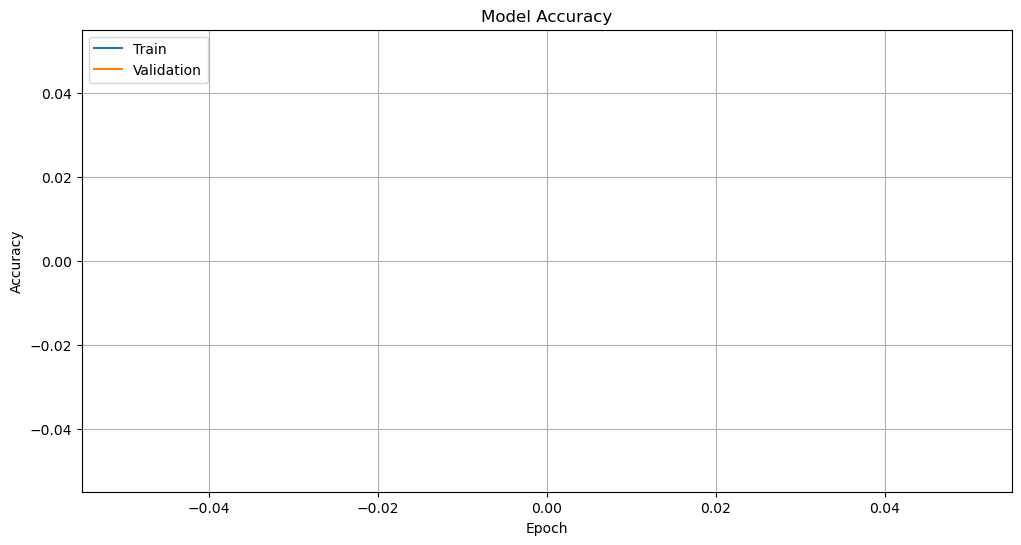

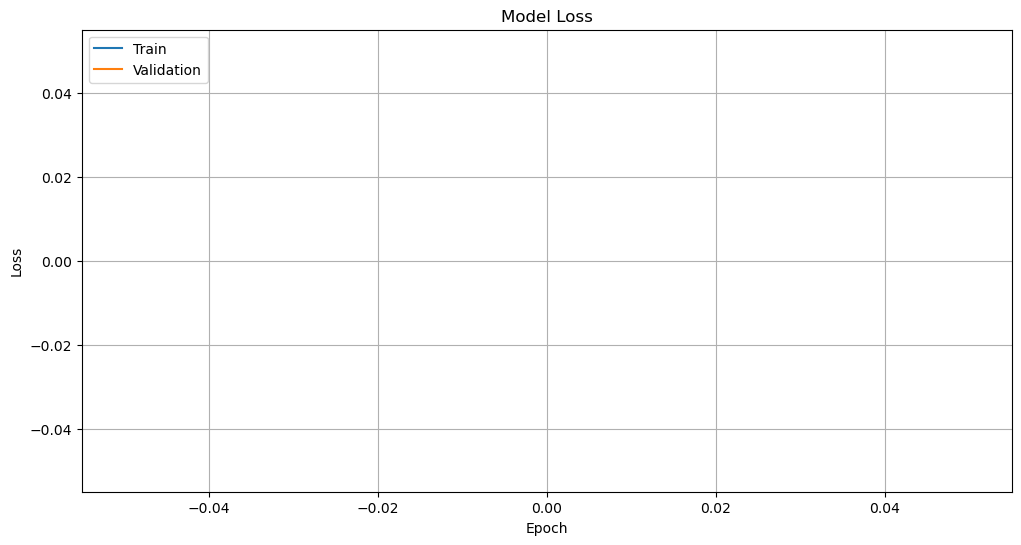

In [49]:
vocab_size = 10000  # Example vocab size
latent_dim = 128  # Example latent dimension
max_length = 100  # Example max length

# Simulate train_x_sequences and train_y
train_x_sequences = np.random.randint(1, vocab_size, size=(40000, max_length))
train_y = np.random.randint(0, 2, size=(40000,))

# Pad sequences
train_x_padded = pad_sequences(train_x_sequences, maxlen=max_length + 1, padding='post', truncating='post')
test_x_sequences = np.random.randint(1, vocab_size, size=(10000, max_length))
test_x_padded = pad_sequences(test_x_sequences, maxlen=max_length + 1, padding='post', truncating='post')

# Split data into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(train_x_padded[:, :-1], train_y, test_size=0.2, random_state=42)

# Define the model_LM architecture
model_LM = Sequential([
    Embedding(input_dim=vocab_size, output_dim=latent_dim, input_length=max_length),
    LSTM(latent_dim, return_sequences=True),
    Dropout(0.2),
    LSTM(latent_dim),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile model_LM to initialize its layers
model_LM.compile(loss=BinaryCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

# Initialize the weights by running a dummy input through the model
dummy_input = tf.random.uniform((1, max_length))
model_LM(dummy_input)

# Print model_LM summary to ensure layers are correct
model_LM.summary()

# Fit the model on the training data
model_LM.fit(train_x, train_y,
             epochs=10,
             batch_size=128,
             validation_data=(val_x, val_y))
print(history.history.keys())

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history.get('accuracy', []))
plt.plot(history.history.get('val_accuracy', []))
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history.get('loss', []))
plt.plot(history.history.get('val_loss', []))
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

<h1 style="text-align: center; font-style: italic; color: tomato;">13. Summary</h1>
<P  style= "font-style:italic; ">>Model involves preprocessing and cleaning textual data from two datasets, tokenizing and padding the sequences, and training an LSTM-based sentiment analysis model. Additionally, it includes training a sequence autoencoder and utilizing a pre-trained Universal Sentence Encoder for embedding. The trained models are evaluated, and accuracy is visualized over epochs to ensure performance. The code demonstrates a comprehensive approach to handling text data for sentiment analysis using deep learning techniques.</P>
